<a href="https://colab.research.google.com/github/harsh-ux/PRML-project/blob/main/Pill_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
train = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTrain_raw.csv')
test = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTest_raw.csv')

# getting the shapes
print("Shape of train :", train.shape)
print("Shape of test :", test.shape)

Mounted at /content/drive
Shape of train : (161297, 7)
Shape of test : (53766, 7)


In [3]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
# as both the dataset contains same columns we can combine them for better analysis
data = pd.concat([train, test])

# checking the shape
data.shape

(215063, 7)

In [6]:
data.describe()

,uniqueID,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


Extracting year,month and day from the date column

In [8]:
# converting the date into datetime format
data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

# now extracting year from date
data['Year'] = data['date'].dt.year

# extracting the month from the date
data['month'] = data['date'].dt.month

# extracting the days from the date
data['day'] = data['date'].dt.day

Check for null values

In [9]:
data.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
Year           False
month          False
day            False
dtype: bool

Add review sentiment column which acts as target variable. It gives a (good,bad)-(1,0) value based on rating of the drug

In [10]:
# feature engineering 
# let's make a new column review sentiment 

data.loc[(data['rating'] >= 5), 'Review_Sentiment'] = 1
data.loc[(data['rating'] < 5), 'Review_Sentiment'] = 0

data['Review_Sentiment'].value_counts()

1.0    161491
0.0     53572
Name: Review_Sentiment, dtype: int64

In [11]:
data['condition'].isnull().sum()

1194

In [12]:
# we will delete the rows so that the data does not overfits 

data = data.dropna(axis = 0)

# checking the new shape of the data
data.shape

(213869, 11)

In [13]:
# importing the important libraries 

import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [15]:
data.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Year', 'month', 'day', 'Review_Sentiment'],
      dtype='object')

In [16]:
df_condition = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
896,Short Stature,1
897,Hemangioma,1
898,Short Stature for Age,1
899,Sleep Paralysis,1
900,Gestational Diabetes,1
901,Gastric Cance,1
902,Gallbladder Disease,1
903,Dermatitis Herpetiformis,1
904,Somatoform Pain Disorde,1
905,Esophageal Variceal Hemorrhage Prophylaxis,1


Removing medical conditions which have only one drug associated with it in the dataset

In [17]:
# setting a df with conditions with only one drug
df_condition_1 = df_condition[df_condition['drugName'] == 1].reset_index()

all_list = set(data.index)

# deleting them
condition_list = []
for i,j in enumerate(data['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

removing the conditions with the word "\span" in it.


In [18]:
all_list = set(data.index)
span_list = []
for i,j in enumerate(data['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

In [19]:
data.shape

(159332, 11)

Applying data cleanup with -


1.   Removing HTML tags
2.   Removing non letters
3.   Convert all to lower case
4.   Remove stopwords
5.   Apply stemming



In [20]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 4. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 5. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 6. space join words
    return( ' '.join(stemming_words))

In [21]:
%time data['review_clean'] = data['review'].apply(review_to_words)

CPU times: user 2min 7s, sys: 1.31 s, total: 2min 9s
Wall time: 2min 9s


Using the entire data as for test and train instead of the original breakup since all have same columns

In [22]:
df_train, df_test = train_test_split(data, test_size = 0.25, random_state = 0)

# checking the shape 
print("Shape of train:", df_train.shape)
print("Shape of test: ", df_test.shape)

Shape of train: (119499, 12)
Shape of test:  (39833, 12)


Making a bag of words using CountVectorise

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 10000, ngram_range = (4, 4))
# cv = CountVectorizer()
pipeline = Pipeline([('vect',cv)])

# df_train_features = pipeline.fit_transform(df_train['review_clean'])
df_train_features = cv.fit_transform(df_train['review_clean']).toarray()
df_test_features = pipeline.fit_transform(df_test['review_clean'])

print("Performing Bag of Words - CountVectorise\n")
print("df_train_features :", df_train_features.shape)
print("df_test_features :", df_test_features.shape)

Performing Bag of Words - CountVectorise

df_train_features : (119499, 10000)
df_test_features : (39833, 10000)


In [24]:
# df_train_features = df_train_features.to_array()

Deep Learning Model

In [25]:
import keras 
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences

In [26]:
# making our dependent variable

y_train = df_train['Review_Sentiment']
y_test = df_test['Review_Sentiment']
solution = y_test.copy()

# Model Structure
model = Sequential()
model.add(Input(shape=(df_train_features.shape[1],)))
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(300))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#  Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# inputs = Input(shape=(df_train_features.shape[1],), sparse=True)
# L1 = (Dense(200))(inputs)
# L1_N = (BatchNormalization())(L1)
# L1_Act = (Activation('relu'))(L1_N)
# L1_Drop = (Dropout(0.5))(L1_Act)
# L2 = (Dense(200))(L1_Drop)
# L2_N = (BatchNormalization())(L2)
# L2_Act = (Activation('relu'))(L2_N)
# L2_Drop = Dropout(0.5)(L2_Act)
# L3 = (Dense(100, activation = 'relu'))(L2_Drop)
# outputs = (Dense(1, activation = 'sigmoid'))(L3)
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               2000200   
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0

In [28]:
print(df_train_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [29]:
df_train['review_clean']

87674     well tri lose weight sinc gave birth son yrs a...
32578     take calan year truli amaz sever life alter mi...
83874     help life entir product clinic learner realiz ...
31622     invega month signific improv qualiti live prio...
149049    differ birth control one other gave horribl sy...
                                ...                        
97639     never tri product allerg microcrystallin cellu...
95939     diagnos adenomyosi due heavi control period ex...
152315    fibromyalgia rheumatoid arthriti wait find med...
117952    prescript ever help doctor gave free sampl aff...
43567     pleas run drug side effect insomnia race heart...
Name: review_clean, Length: 119499, dtype: object

In [30]:
def batch_generator(X, y, batch_size):
    number_of_batches = X.shape[0]/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter < number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

Epoch 1/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4242 - accuracy: 0.8053
Epoch 2/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4220 - accuracy: 0.8059
Epoch 3/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4204 - accuracy: 0.8069
Epoch 4/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4172 - accuracy: 0.8081
Epoch 5/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4174 - accuracy: 0.8083
Epoch 6/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4161 - accuracy: 0.8088
Epoch 7/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4143 - accuracy: 0.8098
Epoch 8/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4137 - accuracy: 0.8101
Epoch 9/10
1868/1868 [==============================] - 15s 8ms/step - loss: 0.4122 - accuracy: 0.8108
Epoch 10/10
1868/1868 [==============================] - 15s 8ms/step - l

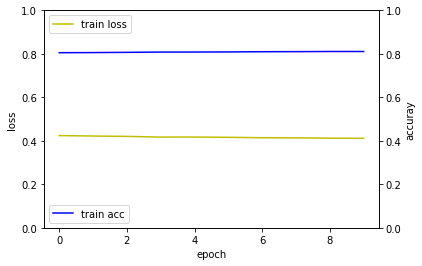

In [34]:
# 4. Train model
hist = model.fit(df_train_features, y_train, epochs=10, batch_size=64)
# steps = 10
# for i in range(steps):
#   print(model.train_on_batch(df_train_features, y_train, ))
# print(model.metrics_names)
# batch_size = 64
# nb_epoch = 5
# model.fit_generator(generator=batch_generator(df_train_features, y_train, batch_size),
#                     epochs=nb_epoch)
# 5. Traing process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()